In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

INPUT_DIR = "../alignment/alignment_2_agent"
OUTPUT_DIR = "results/2_agent/welfare"  # Output directory for generated images

# Sampling configuration
NUM_SAMPLES_PER_COMBINATION = 20  # Number of times to sample each prompt-bid combination
NUM_PROMPTS = 25
SWEEP_VALUES = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

'''
for k samples for each prompt, generate the following images:
1. heatmap for welfare improvement over the baseline VCG
2. show base_alignment remains high
3. regret from truthful bidding?
'''

'\nfor k samples for each prompt, generate the following images:\n1. heatmap for welfare improvement over the baseline VCG\n2. show base_alignment remains high\n3. regret from truthful bidding?\n'

In [3]:
data = {"prompt": [], "sample": [], "quality_score": [], "bid_1": [], "bid_2": [], "base_alignment": [], "agent1_alignment": [], "agent2_alignment": []}
for prompt_num in range(NUM_PROMPTS):
    for sample_num in range(NUM_SAMPLES_PER_COMBINATION):
        for b1 in SWEEP_VALUES:
            filename = f"alignment_p{prompt_num:03}_b{b1:.2f}_{1-b1:.2f}_s{sample_num:02}.json"
            json_path = os.path.join(INPUT_DIR, filename)
            with open(json_path, 'r') as file:
                sample_data = json.load(file)
                data['prompt'].append(sample_data['metadata']['prompt_index'])
                data['sample'].append(sample_data['metadata']['sample_index'])
                data['quality_score'].append(sample_data['quality_score'])
                data['bid_1'].append(sample_data['metadata']['bids'][0])
                data['bid_2'].append(sample_data['metadata']['bids'][1])
                data['base_alignment'].append(sample_data['alignment_scores']['base_alignment'])
                data['agent1_alignment'].append(sample_data['alignment_scores']['agent1_alignment'])
                data['agent2_alignment'].append(sample_data['alignment_scores']['agent2_alignment'])

In [4]:
df = pd.DataFrame.from_dict(data)
df['welfare'] = df['bid_1']*df['agent1_alignment'] + df['bid_2']*df['agent2_alignment']
df['best_welfare'] = df.groupby(['prompt', 'bid_1', 'bid_2'])['welfare'].transform('max')

# Create vcg_baseline: max welfare using alignments from rows where bid_1=1 or bid_2=1, but original bid values
def calculate_vcg_baseline_for_prompt(prompt_df):
    # Get baseline alignment pairs (from rows where bid_1=1 or bid_2=1)
    baseline_rows = prompt_df[(prompt_df['bid_1'] == 1) | (prompt_df['bid_2'] == 1)]
    vcg_baselines = []
    for _, row in prompt_df.iterrows():
        max_welfare = 0
        # Calculate welfare with each baseline alignment pair
        for _, baseline_row in baseline_rows.iterrows():
            welfare = (baseline_row['agent1_alignment'] * row['bid_1'] + 
                      baseline_row['agent2_alignment'] * row['bid_2'])
            max_welfare = max(max_welfare, welfare)
        vcg_baselines.append(max_welfare)
    return pd.Series(vcg_baselines, index=prompt_df.index)

df['vcg_baseline'] = df.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)

/tmp/ipykernel_3572498/561121788.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['vcg_baseline'] = df.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)


In [5]:
welfare_df = df.groupby(['prompt', 'bid_1', 'bid_2']).first().reset_index()[['prompt', 'bid_1', 'bid_2', 'best_welfare', 'vcg_baseline']]
welfare_df['diff'] = (welfare_df['best_welfare'] - welfare_df['vcg_baseline']) / welfare_df['vcg_baseline']
welfare_df_cleaned = welfare_df[~welfare_df['prompt'].isin([14, 24, 16, 12, 5])]
welfare_df_cleaned.groupby(['bid_1', 'bid_2'])['diff'].mean()

bid_1  bid_2
0.0    1.0      0.000000
0.1    0.9      0.018347
0.3    0.7      0.067568
0.5    0.5      0.102131
0.7    0.3      0.066556
0.9    0.1      0.012490
1.0    0.0      0.000000
Name: diff, dtype: float64

In [6]:
welfare_df_cleaned.sort_values(by='diff')

,prompt,bid_1,bid_2,best_welfare,vcg_baseline,diff
30,4,0.3,0.7,0.231543,0.261621,-0.114968
159,22,0.9,0.1,0.260840,0.281641,-0.073856
71,10,0.1,0.9,0.223926,0.240527,-0.069022
43,6,0.1,0.9,0.230273,0.243848,-0.055667
22,3,0.1,0.9,0.240820,0.252734,-0.047141
...,...,...,...,...,...,...
109,15,0.7,0.3,0.260840,0.215674,0.209418
10,1,0.5,0.5,0.257812,0.207764,0.240893
165,23,0.7,0.3,0.210352,0.167236,0.257810
108,15,0.5,0.5,0.256836,0.203125,0.264423


In [45]:
df_cleaned = df[~df['prompt'].isin([14, 24, 16, 12, 5])]
df_cleaned.to_csv("../results/2_agents/data.csv")

In [23]:
def plot_welfare_over_bids(df, k):
    df = df[df['sample'] < k] # Simulate only k samples
    
    df['welfare'] = df['bid_1']*df['agent1_alignment'] + df['bid_2']*df['agent2_alignment']
    df['best_welfare'] = df.groupby(['prompt', 'bid_1', 'bid_2'])['welfare'].transform('max')
    df['vcg_baseline'] = df.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)
    
    welfare_df = df.groupby(['prompt', 'bid_1', 'bid_2']).first().reset_index()[['prompt', 'bid_1', 'bid_2', 'best_welfare', 'vcg_baseline']]
    welfare_df['diff'] = (welfare_df['best_welfare'] - welfare_df['vcg_baseline']) / welfare_df['vcg_baseline']

    stats = welfare_df.groupby(['bid_1', 'bid_2'])['diff'].agg(['mean', 'std', 'count']).reset_index()
    stats['se'] = stats['std'] / np.sqrt(stats['count'])  # Standard error
    error_bars = stats['se']  # Just standard error (smaller)

    stats['bid_combo'] = stats['bid_1'].astype(str) + '/' + stats['bid_2'].astype(str)
    
    plt.style.use('default')  # White background
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    bars = ax.bar(stats['bid_combo'], stats['mean'], 
                yerr=error_bars, 
                capsize=5, 
                alpha=0.8,
                color='steelblue',
                edgecolor='navy',
                linewidth=1.2)
    ax.set_xlabel('Bid Combination (Agent 1 / Agent 2)', fontsize=15)
    ax.set_ylabel(f'Mean Welfare Improvement ± SE', fontsize=15)
    ax.set_title(f'Welfare Improvement Over VCG Baseline, {k} samples', 
                fontsize=16, pad=20)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='No Improvement')
    for i, (bar, mean_val, err) in enumerate(zip(bars, stats['mean'], error_bars)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + err + 0.001,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=14)
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=15)
    ax.set_ylim(bottom=-0.005)
    plt.tight_layout()
    return plt

def calculate_vcg_baseline_for_prompt(prompt_df):
    baseline_rows = prompt_df[(prompt_df['bid_1'] == 1) | (prompt_df['bid_2'] == 1)]
    vcg_baselines = []
    for _, row in prompt_df.iterrows():
        max_welfare = 0
        for _, baseline_row in baseline_rows.iterrows():
            welfare = (baseline_row['agent1_alignment'] * row['bid_1'] + 
                    baseline_row['agent2_alignment'] * row['bid_2'])
            max_welfare = max(max_welfare, welfare)
        vcg_baselines.append(max_welfare)
    return pd.Series(vcg_baselines, index=prompt_df.index)

In [24]:
def plot_welfare_over_k(df, k_list):
    k_summary = []
    bid_combo_data = {}
    
    for k in k_list:
        df_k = df[df['sample'] < k].copy()
        df_k['welfare'] = df_k['bid_1']*df_k['agent1_alignment'] + df_k['bid_2']*df_k['agent2_alignment']
        df_k['best_welfare'] = df_k.groupby(['prompt', 'bid_1', 'bid_2'])['welfare'].transform('max')
        df_k['vcg_baseline'] = df_k.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)
        
        welfare_df_k = df_k.groupby(['prompt', 'bid_1', 'bid_2']).first().reset_index()[['prompt', 'bid_1', 'bid_2', 'best_welfare', 'vcg_baseline']]
        welfare_df_k['diff'] = (welfare_df_k['best_welfare'] - welfare_df_k['vcg_baseline']) / welfare_df_k['vcg_baseline']
        
        # Overall average
        k_summary.append({'k': k, 'mean': welfare_df_k['diff'].mean(), 'se': welfare_df_k['diff'].std()/np.sqrt(len(welfare_df_k))})
        
        # By bid combination
        bid_stats = welfare_df_k.groupby(['bid_1', 'bid_2'])['diff'].agg(['mean', 'std', 'count']).reset_index()
        bid_stats['se'] = bid_stats['std'] / np.sqrt(bid_stats['count'])
        bid_stats['bid_combo'] = bid_stats['bid_1'].astype(str) + '/' + bid_stats['bid_2'].astype(str)
        bid_combo_data[k] = bid_stats
    
    k_df = pd.DataFrame(k_summary)
    k_labels = [f'{k}' for k in k_list]  # Categorical labels
    
    plt.style.use('default')  # White background
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='white')
    ax1.set_facecolor('white')
    # ax2.set_facecolor('white')
    
    # Plot 1: Overall average welfare improvement
    bars1 = ax1.bar(k_labels, k_df['mean'], yerr=k_df['se'], capsize=5, alpha=0.8, color='darkgreen', edgecolor='darkblue')
    ax1.tick_params(axis='both', labelsize=14)
    ax1.set_xlabel('Number of Samples (k)', fontsize=15)
    ax1.set_ylabel('Average Welfare Improvement ± SE', fontsize=15)
    ax1.set_title('Average Welfare Improvement vs Sample Size', fontsize=16, pad=20)
    
    for bar, row in zip(bars1, k_df.itertuples()):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + row.se + 0.0003, 
                f'{row.mean:.4f}', ha='center', va='bottom', fontsize=14)
    
    ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    # ax1.legend(loc='upper right', fontsize=15)
    
    # Plot 2: By bid combination
    bid_combos = bid_combo_data[k_list[0]]['bid_combo'].tolist()
    x_pos = np.arange(len(bid_combos))
    width = 0.2

    plt.tight_layout()
    return plt

/tmp/ipykernel_3572498/790794981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['welfare'] = df['bid_1']*df['agent1_alignment'] + df['bid_2']*df['agent2_alignment']
/tmp/ipykernel_3572498/790794981.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['best_welfare'] = df.groupby(['prompt', 'bid_1', 'bid_2'])['welfare'].transform('max')
/tmp/ipykernel_3572498/790794981.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future ver

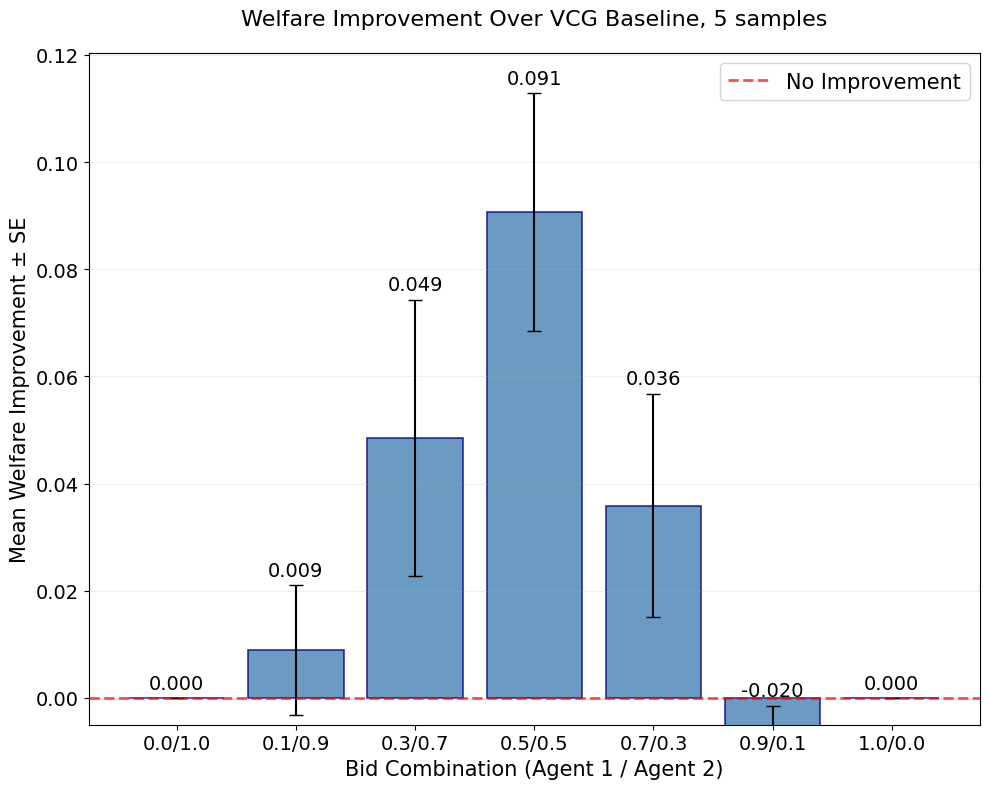

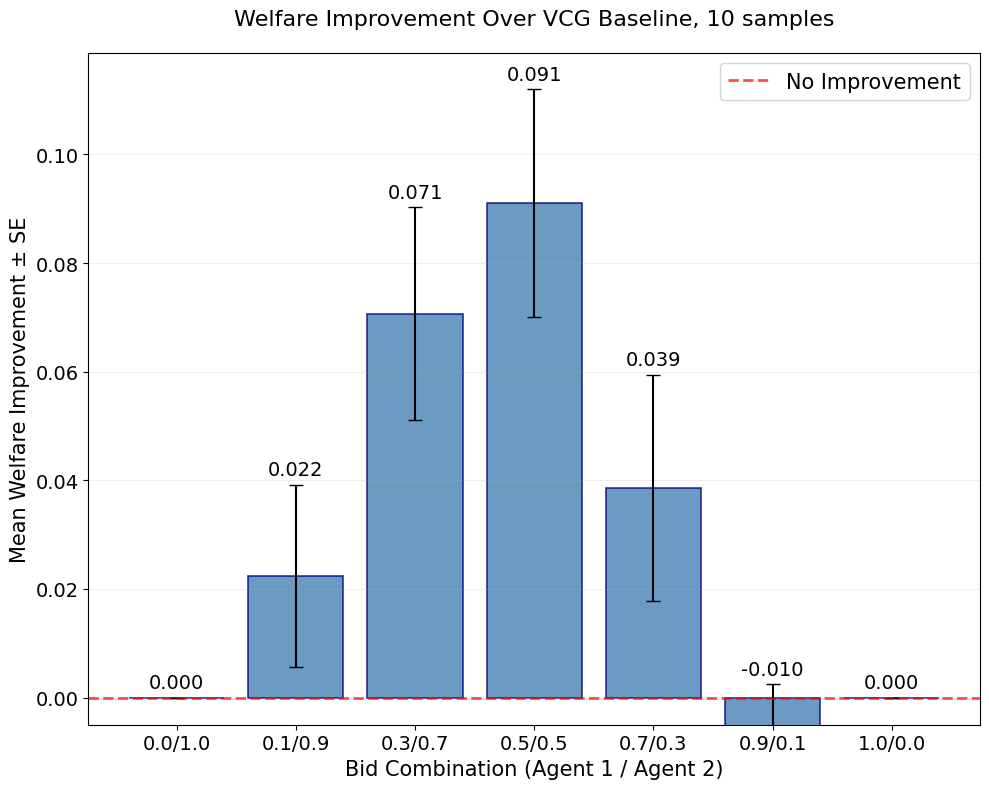

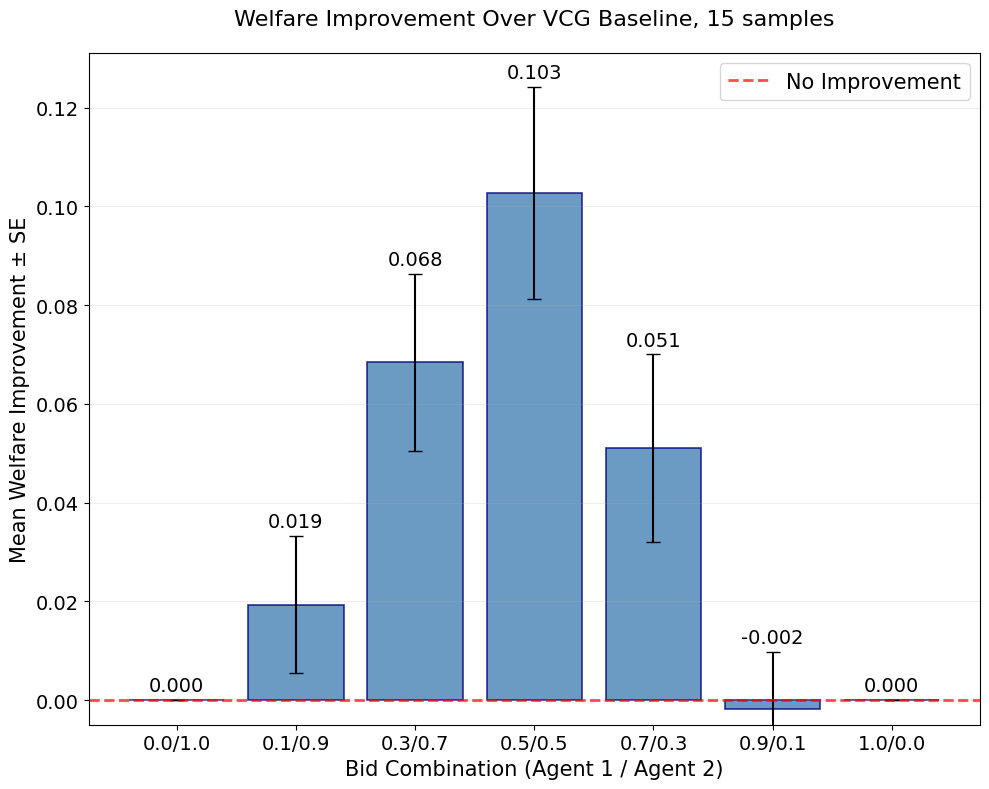

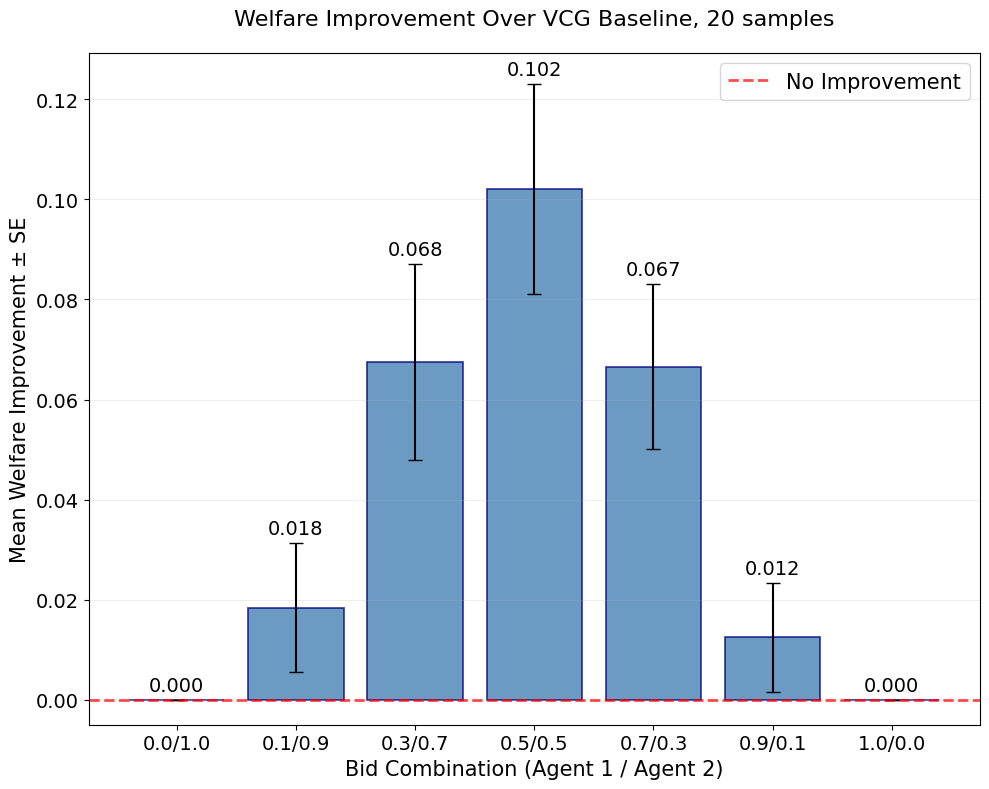

In [ ]:
for k in [5, 10, 15, 20]:
    plt = plot_welfare_over_bids(df_cleaned, k)
    # plt.savefig(f'../results/2_agents/welfare_{k}.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_3572498/833825928.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_k['vcg_baseline'] = df_k.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)
/tmp/ipykernel_3572498/833825928.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_k['vcg_baseline'] = df_k.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)
/t

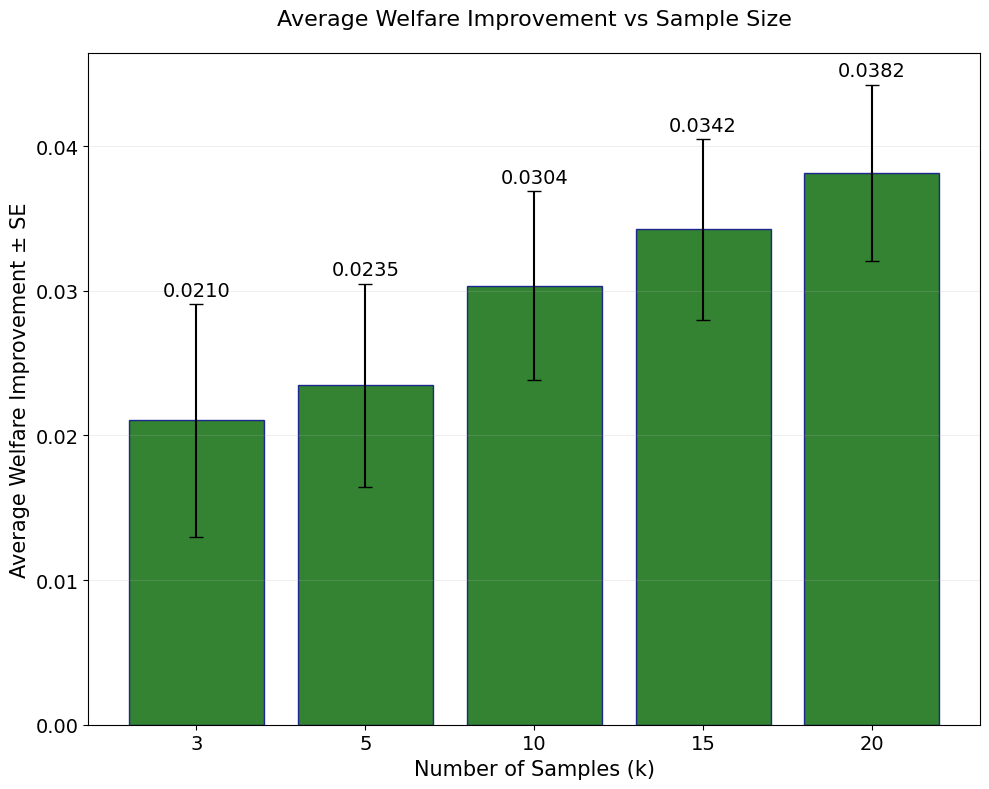

In [26]:
plt = plot_welfare_over_k(df_cleaned, [3, 5, 10, 15, 20])
# plt.savefig(f'../results/2_agents/welfare_across_k.png', dpi=300, bbox_inches='tight')

In [27]:
# bid monotonicity, show average alignment over bid_1 values, with bid_1 values on the x axis, and shading in SE along the line plot
def plot_bid_monotonicity(df, remove_endpoints=False):
    # Group by bid_1 and calculate statistics for both agent alignments
    agent1_stats = df.groupby('bid_1')['agent1_alignment'].agg(['mean', 'std', 'count']).reset_index()
    agent1_stats['se'] = agent1_stats['std'] / np.sqrt(agent1_stats['count'])
    
    agent2_stats = df.groupby('bid_1')['agent2_alignment'].agg(['mean', 'std', 'count']).reset_index()
    agent2_stats['se'] = agent2_stats['std'] / np.sqrt(agent2_stats['count'])
    
    # Option to remove endpoints (0 and 1)
    if remove_endpoints:
        agent1_stats = agent1_stats[(agent1_stats['bid_1'] != 0.0) & (agent1_stats['bid_1'] != 1.0)]
        agent2_stats = agent2_stats[(agent2_stats['bid_1'] != 0.0) & (agent2_stats['bid_1'] != 1.0)]
    
    plt.style.use('default')  # White background
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    # Plot Agent 1 alignment vs bid_1
    ax.plot(agent1_stats['bid_1'], agent1_stats['mean'], 'o-', linewidth=2, markersize=8, 
            color='steelblue', label='Agent 1 Alignment', markeredgecolor='navy', markeredgewidth=1)
    ax.fill_between(agent1_stats['bid_1'], 
                    agent1_stats['mean'] - agent1_stats['se'],
                    agent1_stats['mean'] + agent1_stats['se'],
                    alpha=0.3, color='steelblue')
    
    # Plot Agent 2 alignment vs bid_1 (should be inverse relationship)
    ax.plot(agent2_stats['bid_1'], agent2_stats['mean'], 's--', linewidth=2, markersize=8,
            color='darkgreen', label='Agent 2 Alignment', markeredgecolor='darkblue', markeredgewidth=1)
    ax.fill_between(agent2_stats['bid_1'], 
                    agent2_stats['mean'] - agent2_stats['se'],
                    agent2_stats['mean'] + agent2_stats['se'],
                    alpha=0.3, color='darkgreen')
    
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('Agent 1 Bid Value', fontsize=15)
    ax.set_ylabel('Average Alignment Score ± SE', fontsize=15)
    
    ax.set_title(f'Bid Monotonicity: Alignment Scores vs Bid Values', fontsize=16, pad=20)

    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(fontsize=15, loc='lower center')
    
    # Adjust x-axis limits based on endpoint removal
    if remove_endpoints:
        ax.set_xlim(0.05, 0.95)
    else:
        ax.set_xlim(-0.05, 1.05)
    
    plt.tight_layout()
    return plt

In [43]:
def plot_image_quality(df):
    # Group by bid_1 and calculate statistics for both agent alignments
    agent1_stats = df.groupby('bid_1')['quality_score'].agg(['mean', 'std', 'count']).reset_index()
    agent1_stats['se'] = agent1_stats['std'] / np.sqrt(agent1_stats['count'])
   
    plt.style.use('default')  # White background
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    # Plot Agent 1 alignment vs bid_1
    ax.plot(agent1_stats['bid_1'], agent1_stats['mean'], 'o-', linewidth=2, markersize=8, 
            color='purple', markeredgecolor='navy', markeredgewidth=1)
    ax.fill_between(agent1_stats['bid_1'], 
                    agent1_stats['mean'] - agent1_stats['se'],
                    agent1_stats['mean'] + agent1_stats['se'],
                    alpha=0.3, color='purple')
    
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('Agent 1 Bid Value', fontsize=15)
    ax.set_ylabel('Average Image Quality ± SE', fontsize=15)
    
    ax.set_title(f'Image Quality Across Bid Values', fontsize=16, pad=20)

    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_ylim(0.475, 0.525)
    
    plt.tight_layout()
    return plt

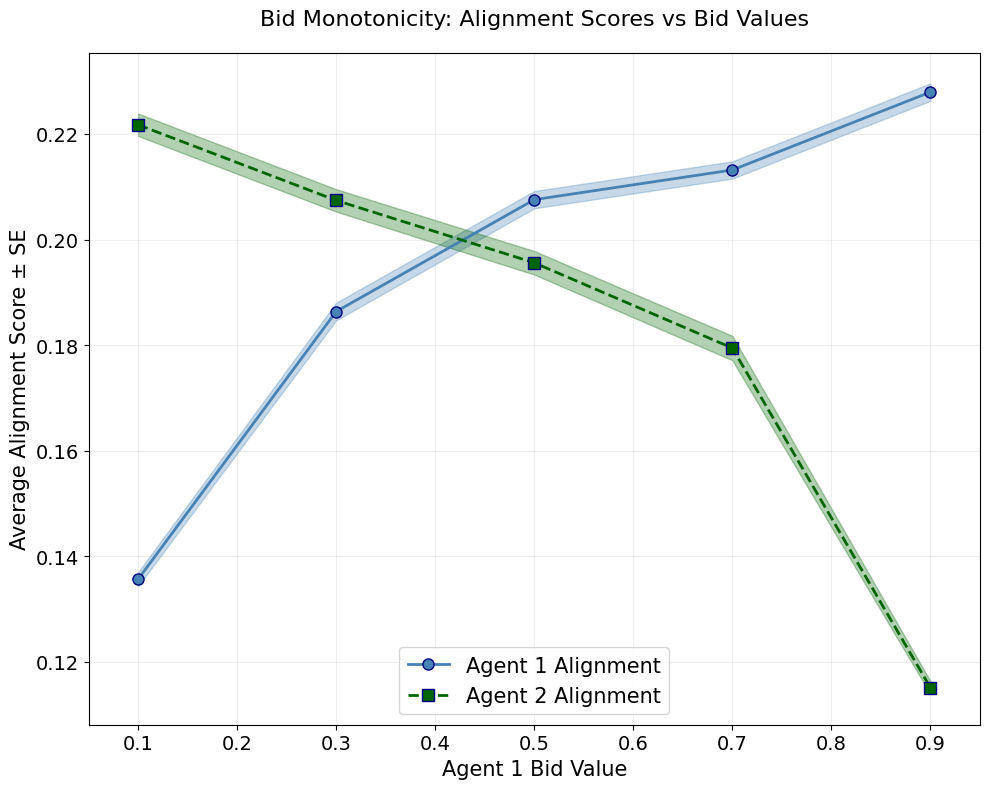

In [29]:
# Plot bid monotonicity
plt = plot_bid_monotonicity(df_cleaned, remove_endpoints=True)
plt.savefig(f'../results/2_agents/bid_monotonicity.png', dpi=300, bbox_inches='tight')
plt.show()

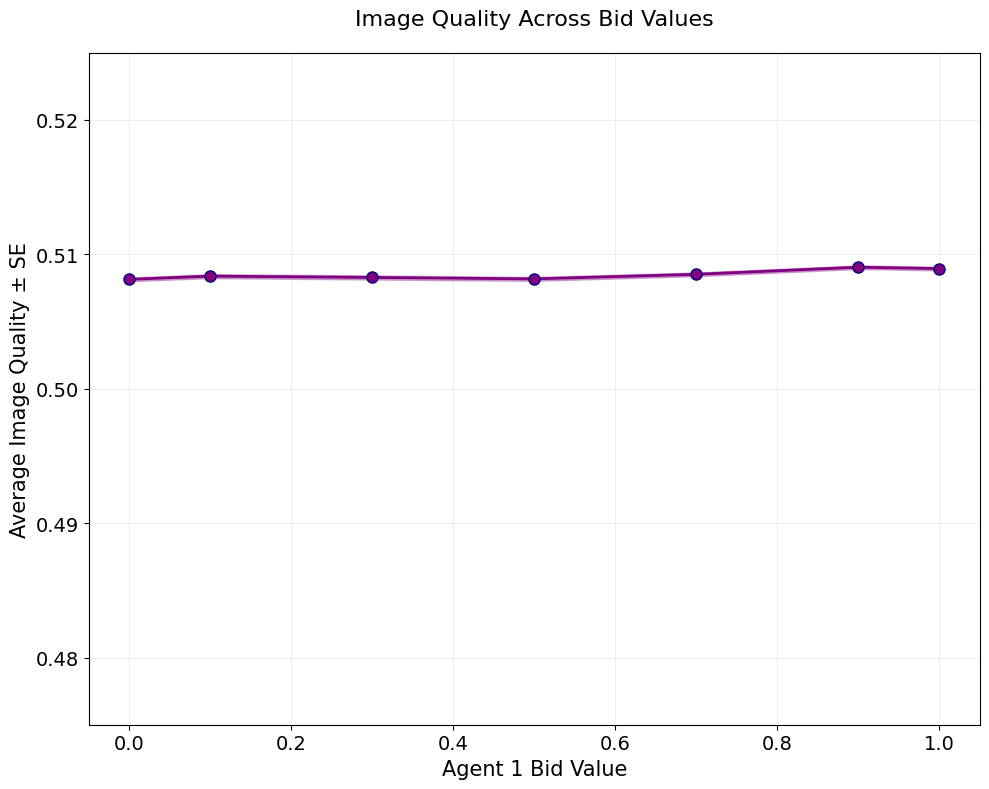

In [44]:
plt = plot_image_quality(df_cleaned)
plt.savefig(f'../results/2_agents/image_quality.png', dpi=300, bbox_inches='tight')
plt.show()